In [1]:
import numpy as np

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# What is inside?
for f in dataset.files:
    print(f)

EAT
S
xyz
Z


In [29]:
# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

n_molecules = len(xyz)
print('The number of molecules in the dataset is {:d}.'.format(n_molecules))

The number of molecules in the dataset is 41537.


In [30]:
from tqdm import tqdm
from scipy.spatial.distance import pdist

# Descriptor
def descriptor(R):
    
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        D.append(1./pdist(R[i]))
    
    return D

d = descriptor(xyz)

# Making all descriptor entries of the same size
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]

  0%|          | 0/41537 [00:00<?, ?it/s]

100%|██████████| 41537/41537 [00:00<00:00, 121065.74it/s]


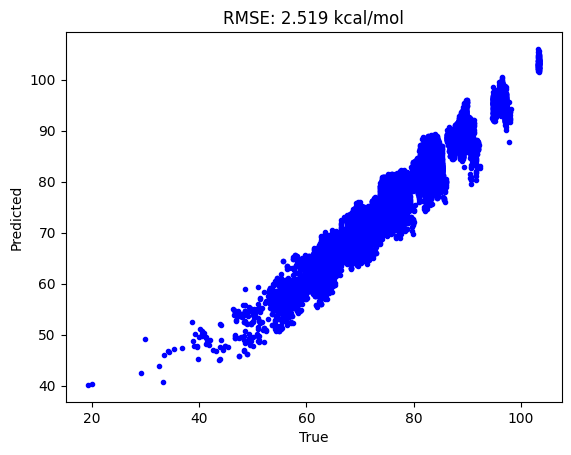

In [4]:
from sklearn import linear_model
import matplotlib.pyplot as plt

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [1]:
import numpy as np
from tqdm import tqdm
from sklearn import linear_model
import matplotlib.pyplot as plt

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

In [2]:
# descriptor
def coulomb_to_feature(molecules):
    n_molecules = len(molecules)
    max_n_atoms = np.max([len(_) for _ in molecules])
    feature_array = []

    for molecule_idx in tqdm(range(n_molecules)):

        atoms = molecules[molecule_idx]
        atoms_charges = Z[molecule_idx]

        c_max = np.zeros((max_n_atoms, max_n_atoms))
        
        dist_matrix = np.linalg.norm(atoms[:, np.newaxis] - atoms[np.newaxis, :], axis=2) # **2
        charges_matrix = np.outer(atoms_charges, atoms_charges)
        M = np.divide(charges_matrix, dist_matrix, out=np.zeros(charges_matrix.shape, dtype=float), where=dist_matrix!=0)
        diagonal = 0.5 * np.power(atoms_charges, 2.4)
        M_full = M + np.diag(diagonal)

        c_max[:M_full.shape[0], :M_full.shape[0]] = np.add(c_max[:M_full.shape[0], :M_full.shape[0]], M_full)

        feature_array.append(c_max.flatten())
    
    return feature_array

descriptor = coulomb_to_feature(xyz)

  0%|          | 0/41537 [00:00<?, ?it/s]

100%|██████████| 41537/41537 [00:02<00:00, 15709.93it/s]


In [3]:
# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(descriptor, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(descriptor)).mean())

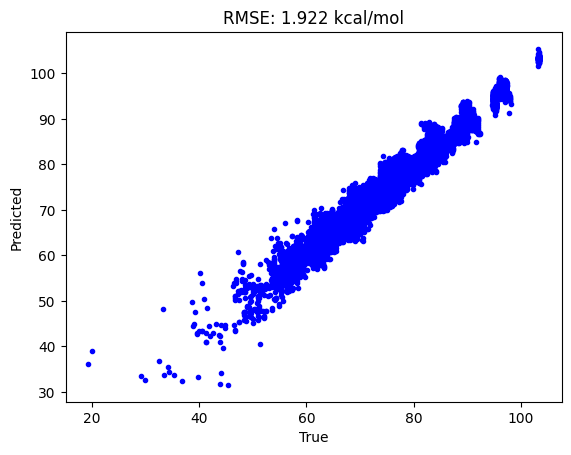

In [4]:
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(descriptor), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()